# Uncertainty and Sensitivity Analyses <a class="anchor" id="top"></a>

* **Prepared by:**

    - [Yalin Li](mailto:zoe.yalin.li@gmail.com)

* **Covered topics:**

    - [1. Model, Parameter, and Metric](#s1)
    - [2. Uncertainty Analysis](#s2)
    - [3. Sensitivity Analysis](#s3)

To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan/main?filepath=%2Fdocs%2Fsource%2Ftutorials).

---
### Note

This tutorial is still under development and will be updated soon

---

In [1]:
import qsdsan as qs
print(f'This tutorial was made with qsdsan v{qs.__version__}.')

This tutorial was made with qsdsan v0.3.9.


## 1. `Model`, `Parameter`, and `Metric` <a class="anchor" id="s1"></a>
To perform uncertainty and sensitivity analyses, we firstly need to use the `Model` class to establish a system model and link it to the system we are interested in.

Let's make a very simple system with a splitter, a heat exchanger, and a mixing tank

In [4]:
cmps = qs.Components.load_default()
qs.set_thermo(cmps)
ww1 = qs.WasteStream.codstates_inf_model('ww1', 1000)
ww2 = qs.WasteStream.bodbased_inf_model('ww2', 100)

/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/qsdsan/_waste_stream.py:945: UserWarning: ignored concentration specified for H2O:0.0
  warn(f'ignored concentration specified for {bulk_liquid_ID}:{C_bulk}')


/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: RuntimeWarning: <Splitter: S1> has been replaced in registry
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/biosteam/utils/piping.py:216: RuntimeWarning: <Stream: to_HX> has been replaced in registry
  else dock(Stream(i, thermo=thermo)) for i in streams]
/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/biosteam/utils/piping.py:216: RuntimeWarning: <Stream: to_mixer> has been replaced in registry
  else dock(Stream(i, thermo=thermo)) for i in streams]
/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: RuntimeWarning: <HXutility: H1> has been replaced in registry
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/IPython/core/interactiveshell.p

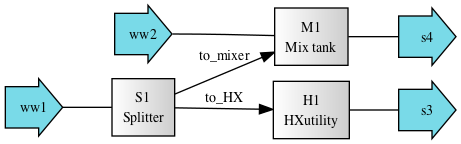

In [6]:
su = qs.sanunits
S1 = su.Splitter('S1', ins=ww1, outs=('to_HX', 'to_mixer'), split=0.2)
H1 = su.HXutility('H1', ins=S1-0, T=273.15+50)
M1 = su.MixTank('M1', ins=(S1-1, ww2), tau=2)
sys = qs.System('sys', path=(S1, H1, M1))
sys.simulate()
sys.diagram()

[Back to top](#top)